# Comparing CC3 and CC2

Notebook to check how CC2 and CC3 models compare, because currently the results coming out look wrong.

In [1]:
cc2_showerflow_path = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/p22_th90_ph90_en10-100/ShowerFlow_original_nb10_inputs36893488147419103231_best.pth"
cc3_showerflow_path = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_best.pth"
#cc3_showerflow_path = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_dhist_best.pth"
#cc3_showerflow_path = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_original_nb10_inputs8070450532247928831_fnorms_best.pth"

cc2_diffusion_path = "/data/dust/user/dayhallh/point-cloud-diffusion-logs/from_anatoli/CC2/CD_2023_07_07__16_32_09/ckpt_0.000000_1120000.pt"

# must use config.diffusion_pointwise_hidden_l1 = 32
#cc3_diffusion_path = "/data/dust/user/dayhallh/point-cloud-diffusion-logs/from_anatoli/CC3/CaloClouds3_CD_small_2025_01_07__08_26_02/ckpt_0.000000_999000.pt"

cc3_diffusion_path = "/data/dust/user/dayhallh/point-cloud-diffusion-logs/sim-E1261AT600AP180-180/Anatoliis_cc_2.pt"

from pointcloud.config_varients import caloclouds_3_simple_shower, caloclouds_2
from pointcloud.evaluation.bin_standard_metrics import get_caloclouds_models

cc_2_configs = caloclouds_2.Configs()
cc_2_configs.distillation = True
cc_models = get_caloclouds_models(cc2_diffusion_path, cc2_showerflow_path, caloclouds_names="CC2", configs=cc_2_configs)
cc_3_configs = caloclouds_3_simple_shower.Configs()
#cc_3_configs.diffusion_pointwise_hidden_l1 = 32
#cc_3_configs.distillation = True
cc_models.update(get_caloclouds_models(cc3_diffusion_path, cc3_showerflow_path, caloclouds_names="CC3", configs=cc_3_configs))
print(cc_models.keys())


/data/dust/user/dayhallh/point-cloud-diffusion-logs/from_anatoli/CC2/CD_2023_07_07__16_32_09/ckpt_0.000000_1120000.pt
Found 1 saved models
/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/p22_th90_ph90_en10-100/ShowerFlow_original_nb10_inputs36893488147419103231_best.pth
/data/dust/user/dayhallh/point-cloud-diffusion-logs/sim-E1261AT600AP180-180/Anatoliis_cc_2.pt
original_nb4_fnorms_wo[0, 1, 4] has best loss -145.9351401815609
alt1_nb4_fnorms_wo[0, 1, 4] has best loss -147.62754416952328
Found 10 saved models
/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_best.pth
dict_keys(['CC2', 'CC3'])


Now get some sample conditioning values with which to compare the models.
The same ones will be used for both models, however, the expected scaling may be different.


In [2]:
from pointcloud.data.conditioning import read_raw_regaxes_withcond
all_cond_configs = caloclouds_2.Configs()
all_cond_configs.dataset_path_in_storage = False
all_cond_configs.dataset_path = "/data/dust/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/p22_th90_ph90_en10-100_seed{}_all_steps.hdf5"
all_cond_configs.n_dataset_files = 10
all_cond_configs.cond_features_names = ["energy", "points", "p_norm_local"]
all_cond_configs.cond_features = 5
if True:
    cond, events = read_raw_regaxes_withcond(all_cond_configs, total_size=1_000, for_model=['diffusion'])
print(cond[:10])


Selecting evenly spaced events
tensor([[4.3710e+01, 2.8140e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.2829e+01, 9.9600e+02, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [6.7785e+01, 4.1160e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.4652e+01, 1.0870e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.9282e+01, 1.4110e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [7.2836e+01, 4.1840e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [2.5205e+01, 1.8940e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [5.7934e+01, 2.4680e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [7.3653e+01, 4.1410e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [2.8710e+01, 2.0940e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00]],
       dtype=torch.float64)


Make cond for both CC2 and CC3


In [18]:
all_cond_meta.incident_rescale

array(100)

In [70]:
from pointcloud.data.conditioning import normalise_cond_feats
from pointcloud.utils.metadata import Metadata
all_cond_meta = Metadata(all_cond_configs)
original_cc2_max_points = 6_000
normalised_cond2 = cond.clone()
normalised_cond3 = cond.clone()
#normalised_cond[:, 3] = 0
#normalised_cond[:, 4] = 1
normalised_cond2[:, 0] /= all_cond_meta.incident_rescale
normalised_cond3[:, 0] /= 127
normalised_cond2[:, 1] = (normalised_cond[:, 1]/original_cc2_max_points)*2 - 1
showerflow_cond = {"CC2": normalised_cond2[:, [0]], "CC3": normalised_cond3[:, [0, 2, 3, 4]]}
# for the diffusion models, the energy goes between -1 and 1
normalised_cond2[:, 0] = normalised_cond2[:, 0]*2 - 1
normalised_cond3[:, 0] = normalised_cond3[:, 0]*2 - 1
diffusion_cond = {"CC2": normalised_cond2[:, [0, 1]], "CC3":normalised_cond3[:, [0, 2, 3, 4]]}

In [71]:
conditioned_samples = {}
point_per_event = 100
for name in cc_models:
    diffusion, flow_dist, configs = cc_models[name]
    d_cond = diffusion_cond[name].float()
    s_diffusion = diffusion.sample(d_cond, point_per_event, all_cond_configs)
    s_cond = showerflow_cond[name].float()
    s_showerflow = flow_dist.condition(s_cond).sample([len(s_cond)])
    conditioned_samples[name] = (s_diffusion, s_showerflow)

    

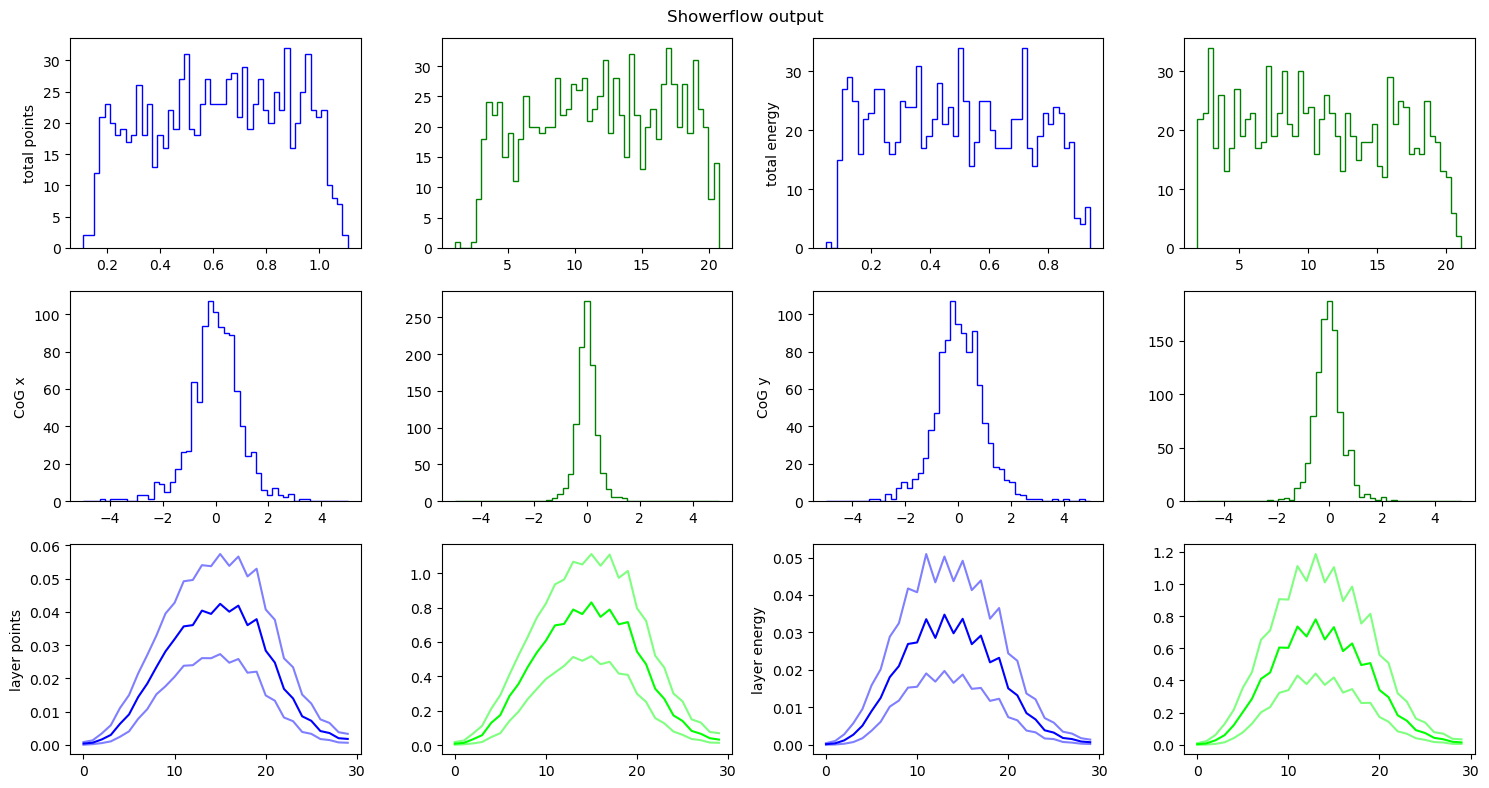

In [72]:
from matplotlib import pyplot as plt
import numpy as np
fig, ax_arr = plt.subplots(3, 4, figsize=(15, 8))
ax_arr = ax_arr.flatten()
fig.suptitle("Showerflow output")
hist2_settings = dict(label='CC2', color='blue', histtype="step", bins=np.linspace(-5, 5, 50))
hist3_settings = dict(label='CC3', color='green', histtype="step", bins=np.linspace(-5, 5, 50))


i=4
ax_arr[i].set_ylabel("CoG x")
cc2_v = conditioned_samples["CC2"][1][:, 4]
cc3_v = conditioned_samples["CC3"][1][:, 0]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i+1].hist(cc3_v, **hist3_settings)

i=6
ax_arr[i].set_ylabel("CoG y")
cc2_v = conditioned_samples["CC2"][1][:, 2]
cc3_v = conditioned_samples["CC3"][1][:, 1]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i+1].hist(cc3_v, **hist3_settings)

i=0
# total points
hist2_settings['bins'] = 50
hist3_settings['bins'] = 50
ax_arr[i].set_ylabel("total points")
cc2_v = conditioned_samples["CC2"][1][:, 0]
cc3_v = conditioned_samples["CC3"][1][:, -60:-30].sum(dim=1)

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i+1].hist(cc3_v, **hist3_settings)

i=8
ax_arr[i].set_ylabel("layer points")
layer_pnts2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -60:-30]
raw_totals = raw.sum(dim=1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_pnts3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_pnts2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_pnts3[:, l] = np.quantile(conditioned_samples["CC3"][1][:, -60+l], quantiles)
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_pnts2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i+1].plot(range(30), layer_pnts3[j], color=colour[j])



i=2
# total energy
ax_arr[i].set_ylabel("total energy")
cc2_v = conditioned_samples["CC2"][1][:, 1]
cc3_v = conditioned_samples["CC3"][1][:, -30:].sum(dim=1)

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i+1].hist(cc3_v, **hist3_settings)

i=10
ax_arr[i].set_ylabel("layer energy")
layer_e2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -30:]
raw_totals = raw.sum(dim=1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_e3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_e2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_e3[:, l] = np.quantile(conditioned_samples["CC3"][1][:, -30+l], quantiles)
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_e2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i+1].plot(range(30), layer_e3[j], color=colour[j])

plt.tight_layout()

In [73]:
n_pnts = (events[..., -1] > 0).sum(axis=1)
energy = events[..., -1].sum(axis=1)/all_cond_meta.vis_eng_rescale
cog_x = ((events[..., -1]*events[..., 0]/events[..., [-1]].sum(axis=1)).sum(axis=1)-all_cond_meta.mean_cog[0])/all_cond_meta.std_cog[0]
cog_y = ((events[..., -1]*events[..., 1]/events[..., [-1]].sum(axis=1)).sum(axis=1)-all_cond_meta.mean_cog[1])/all_cond_meta.std_cog[1]


In [77]:
print(all_cond_meta.n_pts_rescale, all_cond_meta.std_cog)
cc3_train_ds_meta = Metadata(caloclouds_3_simple_shower.Configs())
print(cc3_train_ds_meta.n_pts_rescale)
cc_3_meta = Metadata(all_cond_configs)
# we need actual cog for this dataset
cc_3_meta.n_pts_rescale = cc3_train_ds_meta.n_pts_rescale
cc3_vis_eng_rescale = cc3_train_ds_meta.vis_eng_rescale/cc_3_meta.vis_eng_rescale
cc_3_meta.std_cog = np.array([np.std(cog_x), np.std(cog_y), 2.])
print(cc_3_meta.n_pts_rescale, cc_3_meta.std_cog)
cc3_train_ds_meta


5000 [ 0.48370289  0.51969929 12.76039063]
7864
7864 [0.93711166 1.00698206 2.        ]


Metadata for /data/dust/user/akorol/data/AngularShowers_RegularDetector/hdf5_for_CC/sim-E1261AT600AP180-180_file_{}slcio.hdf5
layer_bottom_pos_hdf5: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
half_cell_size_global: 2.5441665649414062
cell_thickness_global: 0.5250244140625
half_cell_size_hdf5: 2.5441665649414062
cell_thickness_hdf5: 1.0
gun_xyz_pos_hdf5: [   0. 1811.    0.]
orientation: hdf5:xyz==local:xyz
gun_xyz_pos_global: [   0.  1804.7  -50. ]
orientation_global: hdf5:xyz==global:zxy
layer_bottom_pos_global: [1811.34020996 1814.46508789 1823.81005859 1826.93505859 1836.2800293
 1839.4050293  1848.75       1851.875      1861.2199707  1864.3449707
 1873.68994141 1876.81494141 1886.16003418 1889.28503418 1898.63000488
 1901.75500488 1911.09997559 1914.22497559 1923.56994629 1926.69494629
 1938.14001465 1943.36499023 1954.81005859 1960.03503418 1971.47998047
 1976.70495605 1988.15002441 1993.375      2004.8

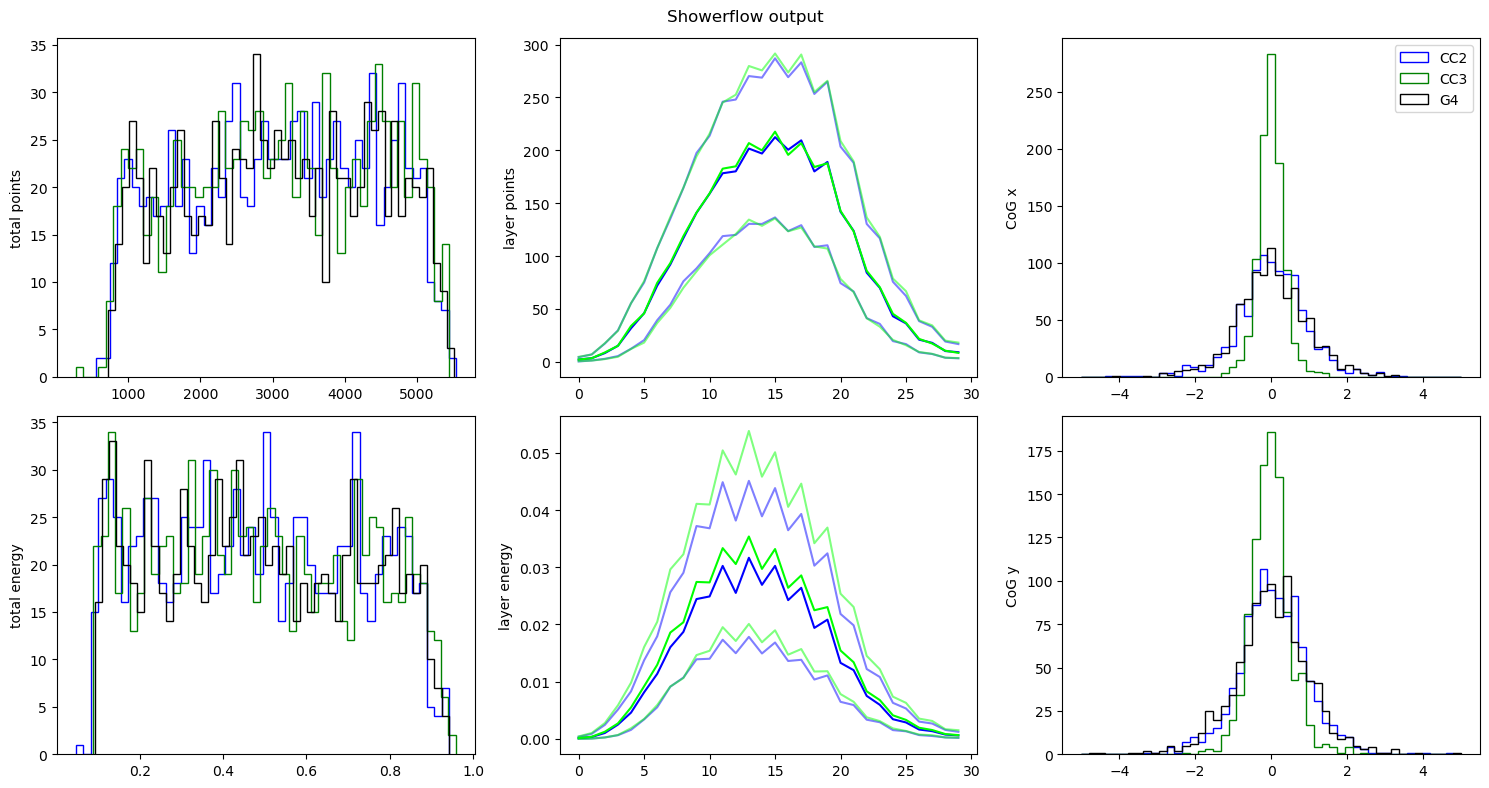

In [78]:
from matplotlib import pyplot as plt
fig, ax_arr = plt.subplots(2, 3, figsize=(15, 8))
ax_arr = ax_arr.flatten()
fig.suptitle("Showerflow output")
hist2_settings = dict(label='CC2', color='blue', histtype="step", bins=np.linspace(-5, 5, 50))
hist3_settings = dict(label='CC3', color='green', histtype="step", bins=np.linspace(-5, 5, 50))
histg4_settings = dict(label='G4', color='k', histtype='step', bins=np.linspace(-5, 5, 50))

i=2
ax_arr[i].set_ylabel("CoG x")
cc2_v = conditioned_samples["CC2"][1][:, 4]#*all_cond_meta.std_cog[0]
cc3_v = conditioned_samples["CC3"][1][:, 0]*cc_3_meta.std_cog[0]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(cog_x, **histg4_settings)
ax_arr[i].legend()

i=5
ax_arr[i].set_ylabel("CoG y")
cc2_v = conditioned_samples["CC2"][1][:, 2]#*all_cond_meta.std_cog[1]
cc3_v = conditioned_samples["CC3"][1][:, 1]*cc_3_meta.std_cog[1]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(cog_y, **histg4_settings)

i=0
# total points
hist2_settings['bins'] = 50
hist3_settings['bins'] = 50
histg4_settings['bins'] = 50
ax_arr[i].set_ylabel("total points")
cc2_v = (float(all_cond_meta.n_pts_rescale)*conditioned_samples["CC2"][1][:, 0]).clip(1, 60_000)
cc3_v = float(cc_3_meta.n_pts_rescale/30)*conditioned_samples["CC3"][1][:, -60:-30].sum(dim=1)

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(n_pnts, **histg4_settings)

i=1
ax_arr[i].set_ylabel("layer points")
layer_pnts2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -60:-30].clip(0, 1)
raw_totals = raw.sum(dim=1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_pnts3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_pnts2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_pnts3[:, l] = float(cc_3_meta.n_pts_rescale)*np.quantile(conditioned_samples["CC3"][1][:, -60+l], quantiles)/30
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_pnts2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_pnts3[j], color=colour[j])



i=3
# total energy
ax_arr[i].set_ylabel("total energy")
cc2_v = conditioned_samples["CC2"][1][:, 1]
cc3_v = cc3_vis_eng_rescale*conditioned_samples["CC3"][1][:, -30:].sum(dim=1)/30

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(energy, **histg4_settings)

i=4
ax_arr[i].set_ylabel("layer energy")
layer_e2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -30:].clip(0, 1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_e3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_e2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_e3[:, l] = np.quantile(cc3_vis_eng_rescale*conditioned_samples["CC3"][1][:, -30+l], quantiles)/30
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_e2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_e3[j], color=colour[j])

plt.tight_layout()

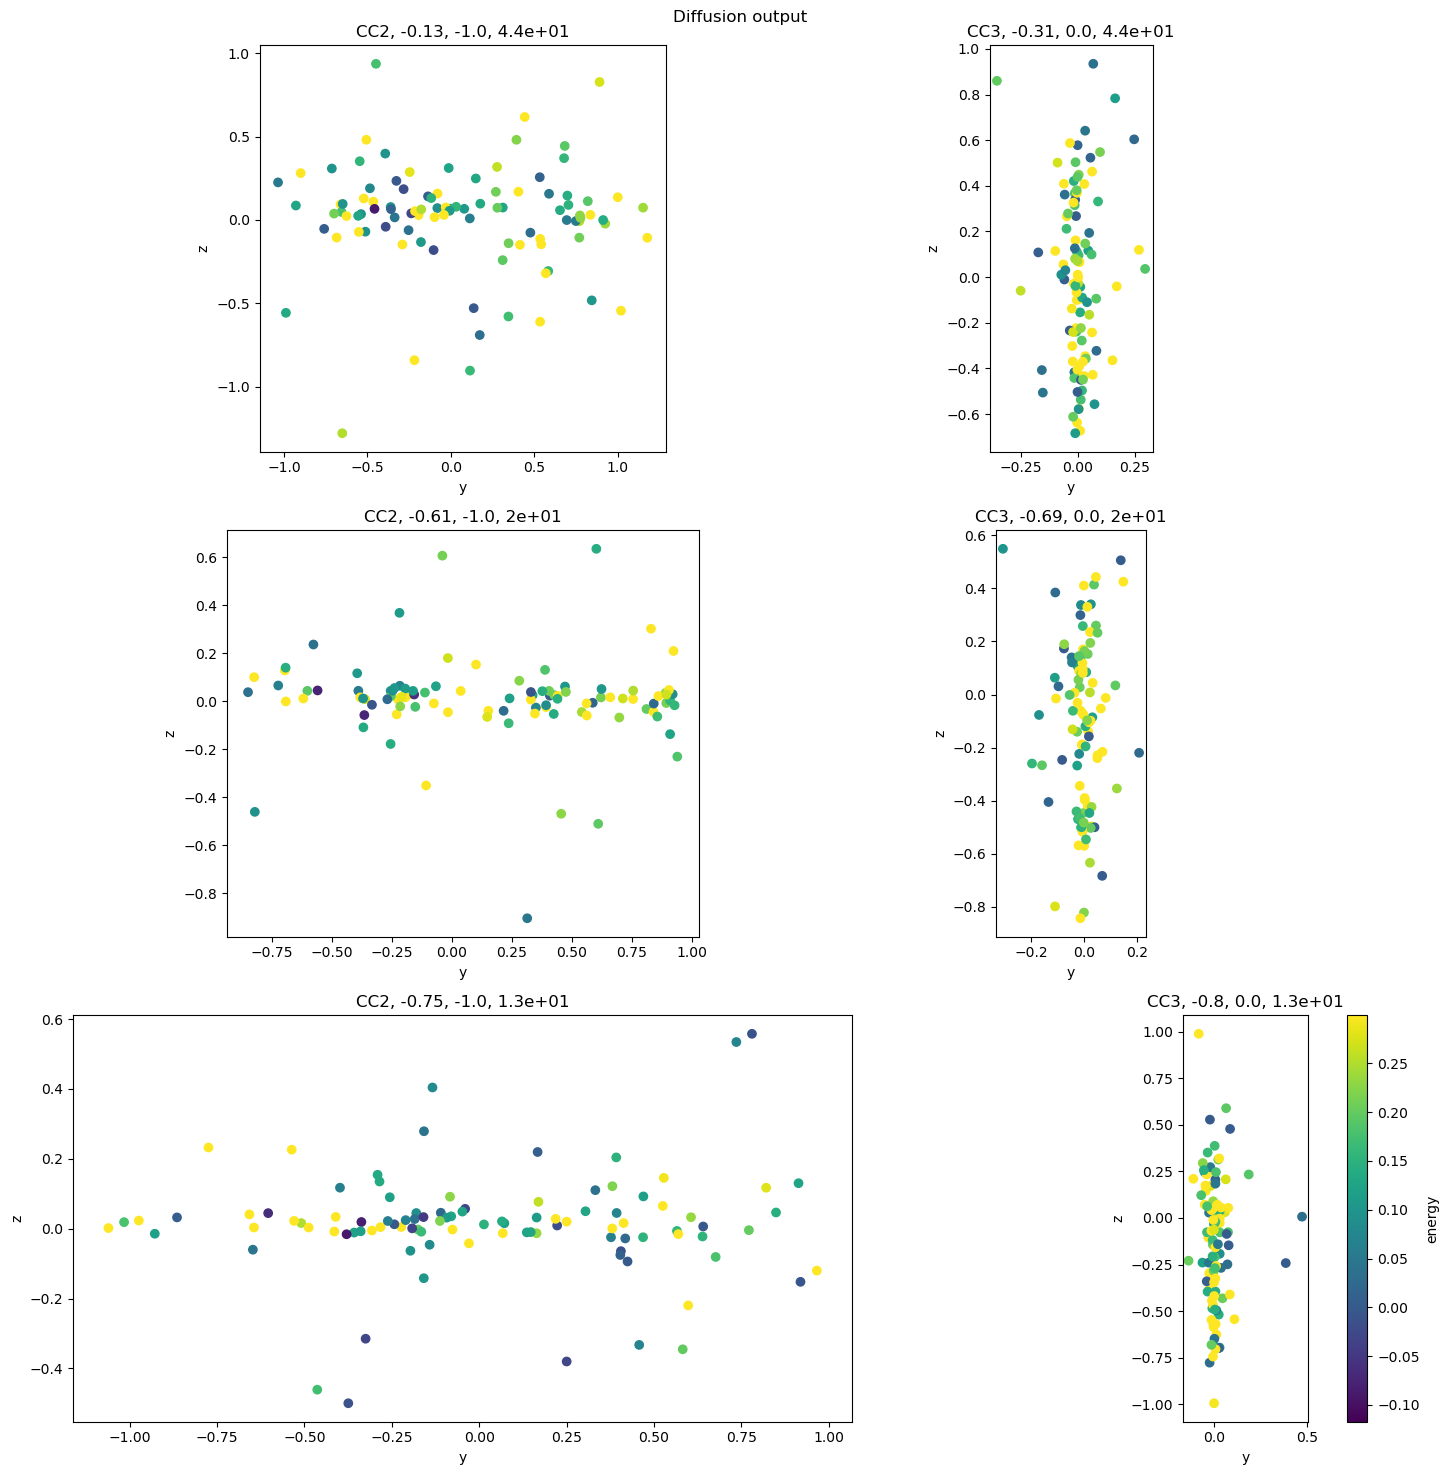

In [76]:
from matplotlib import pyplot as plt
min_energy = min(conditioned_samples["CC2"][0][..., -1].min(),
                 conditioned_samples["CC3"][0][..., -1].min())
max_energy = max(conditioned_samples["CC2"][0][..., -1].max(),
                 conditioned_samples["CC3"][0][..., -1].max())*0.01
use_events = [0, 51, 99]
fig, ax_arr = plt.subplots(len(use_events), 2, figsize=(15, len(use_events)*5))
fig.suptitle("Diffusion output")
for e, event in enumerate(use_events):
    for i, name in enumerate(conditioned_samples):
        s_diffusion, s_showerflow = conditioned_samples[name]
        s_diffusion = s_diffusion.detach()
        ax_arr[e, i].set_aspect(1)
        points = ax_arr[e, i].scatter(s_diffusion[event, :, 1], s_diffusion[event, :, 2], c=s_diffusion[event, :, 3], vmin=min_energy, vmax=max_energy)
        ax_arr[e, i].set_title(f"{name}, {diffusion_cond[name][event, 0]:.2}, {diffusion_cond[name][event, 1]:.2}, {cond[event, 0]:.2}")
        ax_arr[e, i].set_xlabel("y")
        ax_arr[e, i].set_ylabel("z")
cbar = plt.colorbar(points)
cbar.set_label("energy")
plt.tight_layout()

In [34]:
from pointcloud.utils.showerflow_utils import truescale_showerflow_output
model_name = "CC3"
diffusion_m, sf_m, configs_m = cc_models[model_name]

import ipdb
if True:
    all_cond_meta = Metadata(all_cond_configs)
    #ipdb.set_trace()
    all_cond_meta.n_pts_rescale = 5000
    all_cond_meta.vis_eng_rescale = 1
    all_cond_meta.std_cog[:] = 1
    all_cond_meta.mean_cog[:] = 0
    np_ts, energy_ts, cog_x_ts, cog_y_ts, cog_z_ts, clusters_per_layer_ts, e_per_layer_ts = truescale_showerflow_output(conditioned_samples[model_name][1].clone(), configs_m, all_cond_meta)
    if np_ts is None:
        np_ts = clusters_per_layer_ts.sum(dim=1)
    if energy_ts is None:
        energy_ts = e_per_layer_ts.sum(dim=1)
print(np_ts.mean(), cog_x_ts.mean(), cog_y_ts.mean(), clusters_per_layer_ts.mean(), e_per_layer_ts.mean())

tensor(1987.4673) tensor(-0.0242) tensor(-0.0198) tensor(66.2489) tensor(12.0025)


In [35]:
from pointcloud.utils.gen_utils import gen_cond_showers_batch
# CC2
cond_m = {"showerflow":cond[:, [0]], "diffusion": cond[:, [0, 1]]}
diffusion_m, sf_m, configs_m = cc_models["CC2"]
all_cond_configs.device='cpu'
all_cond_configs.distillation = True
import ipdb
if True:
    #ipdb.set_trace()
    cc2_events = gen_cond_showers_batch(diffusion_m, sf_m, cond_m, config=all_cond_configs, metadata=all_cond_meta)

In [36]:
total_points_2s = (cc2_events[:, :, 3] > 0).sum(axis=1)
total_energy_2s = cc2_events[:, :, 3].sum(axis=1)/1000
cog_x_2s = ((cc2_events[..., -1]*cc2_events[..., 0]/cc2_events[..., [-1]].sum(axis=1)).sum(axis=1)-all_cond_meta.mean_cog[0])/all_cond_meta.std_cog[0]
cog_y_2s = ((cc2_events[..., -1]*cc2_events[..., 1]/events[..., [-1]].sum(axis=1)).sum(axis=1)-all_cond_meta.mean_cog[1])/all_cond_meta.std_cog[1]

In [37]:
from pointcloud.utils.gen_utils import gen_cond_showers_batch
# CC3
cond_m = {"showerflow":cond[:, [0, 2, 3, 4]], "diffusion": cond[:, [0, 2, 3, 4]]}
diffusion_m, sf_m, configs_m = cc_models["CC3"]
configs_m.device='cpu'
cc_3_configs.device='cpu'
if True:
    #ipdb.set_trace()
    cc3_events = gen_cond_showers_batch(diffusion_m, sf_m, cond_m, config=configs_m, metadata=all_cond_meta)

In [38]:
cc3_events[0, :, 3]

array([8.66658884e-05, 1.68119505e-01, 8.88605267e-02, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00], shape=(30000,))

In [39]:
total_points_3s = (cc3_events[:, :, 3] > 0).sum(axis=1)
total_energy_3s = cc3_events[:, :, 3].sum(axis=1)/1000
cog_x_3s = ((cc3_events[..., -1]*cc3_events[..., 0]/cc3_events[..., [-1]].sum(axis=1)).sum(axis=1)-cc_3_meta.mean_cog[0])/cc_3_meta.std_cog[0]
cog_y_3s = ((cc3_events[..., -1]*cc3_events[..., 1]/events[..., [-1]].sum(axis=1)).sum(axis=1)-cc_3_meta.mean_cog[1])/cc_3_meta.std_cog[1]

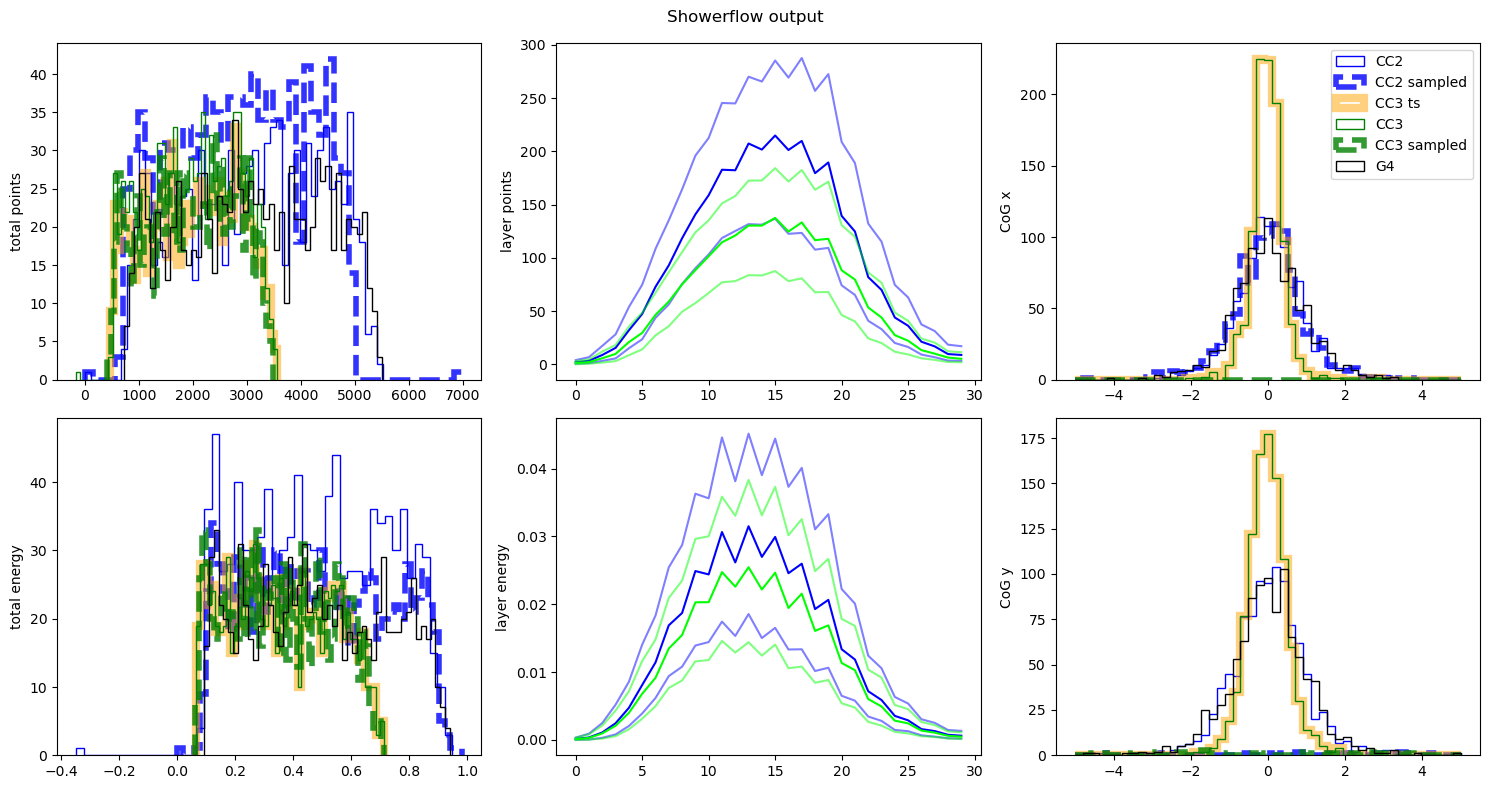

In [40]:
from matplotlib import pyplot as plt
fig, ax_arr = plt.subplots(2, 3, figsize=(15, 8))
ax_arr = ax_arr.flatten()
fig.suptitle("Showerflow output")
hist2_settings = dict(label='CC2', color='blue', histtype="step", bins=np.linspace(-5, 5, 50))
hist2s_settings = dict(label='CC2 sampled', color='blue', histtype="step", linewidth=4, alpha=0.8, linestyle='--', bins=np.linspace(-5, 5, 50))
hist2ts_settings = dict(label=f'{model_name} ts', color='orange', histtype="step", linewidth=6, alpha=0.5, bins=np.linspace(-5, 5, 50))
hist3_settings = dict(label='CC3', color='green', histtype="step", bins=np.linspace(-5, 5, 50))
hist3s_settings = dict(label='CC3 sampled', color='green', histtype="step", linewidth=4, alpha=0.8, linestyle='--', bins=np.linspace(-5, 5, 50))
histg4_settings = dict(label='G4', color='k', histtype='step', bins=np.linspace(-5, 5, 50))
settings = [hist2_settings, hist2s_settings, hist2ts_settings, hist3_settings, hist3s_settings, histg4_settings]

i=2
ax_arr[i].set_ylabel("CoG x")
cc2_v = conditioned_samples["CC2"][1][:, 4]
cc3_v = conditioned_samples["CC3"][1][:, 0]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cog_x_2s, **hist2s_settings)
ax_arr[i].hist(cog_x_ts, **hist2ts_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(cog_x_3s, **hist3s_settings)
ax_arr[i].hist(cog_x, **histg4_settings)
ax_arr[i].legend()

i=5
ax_arr[i].set_ylabel("CoG y")
cc2_v = conditioned_samples["CC2"][1][:, 2]
cc3_v = conditioned_samples["CC3"][1][:, 1]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cog_y_2s, **hist2s_settings)
ax_arr[i].hist(cog_y_ts, **hist2ts_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(cog_y_3s, **hist3s_settings)
ax_arr[i].hist(cog_y, **histg4_settings)

i=0
# total points
for seti in settings:
    seti['bins'] = 50
ax_arr[i].set_ylabel("total points")
cc2_v = (float(all_cond_meta.n_pts_rescale)*conditioned_samples["CC2"][1][:, 0]).clip(1, 60_000)
cc3_v = float(all_cond_meta.n_pts_rescale)*conditioned_samples["CC3"][1][:, -60:-30].sum(dim=1)/30

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(total_points_2s, **hist2s_settings)
ax_arr[i].hist(np_ts, **hist2ts_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(total_points_3s, **hist3s_settings)
ax_arr[i].hist(n_pnts, **histg4_settings)

i=1
ax_arr[i].set_ylabel("layer points")
layer_pnts2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -60:-30].clip(0, 1)
raw_totals = raw.sum(dim=1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_pnts3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_pnts2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_pnts3[:, l] = float(all_cond_meta.n_pts_rescale)*np.quantile(conditioned_samples["CC3"][1][:, -60+l], quantiles)/30
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_pnts2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_pnts3[j], color=colour[j])



i=3
# total energy
ax_arr[i].set_ylabel("total energy")
cc2_v = conditioned_samples["CC2"][1][:, 1]
cc3_v = conditioned_samples["CC3"][1][:, -30:].sum(dim=1)/30

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(total_energy_2s, **hist2s_settings)
ax_arr[i].hist(energy_ts/1000, **hist2ts_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(total_energy_3s, **hist3s_settings)
ax_arr[i].hist(energy, **histg4_settings)

i=4
ax_arr[i].set_ylabel("layer energy")
layer_e2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -30:].clip(0, 1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_e3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_e2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_e3[:, l] = np.quantile(conditioned_samples["CC3"][1][:, -30+l], quantiles)/30
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_e2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_e3[j], color=colour[j])

plt.tight_layout()